In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns

Objetivos do Script:

Esse script tem como objetivo ler os dados que foram capturados da nossa amostra piloto e realizar alguns estudos em cima desses dados. 

Os 6 primeiros tópicos que eu separei abaixo são utilizados na grande maioria dos scripts de tratamento de dados desse estudo. 
Deixei padronizado para que seja possivel tratar simulações com um dispositivo ou vários.

Sumário:
  - Leitura dos dados
  - Separar publicações e confirmação de entrega por dispositivo simulado.
  - Criação de um dataframe com informações capturadas. 
  - Medidas de tendência centrar por dispositivo
  - Medidas de tendência centrar de todos os dispositivos.
  - Gráfico de dispersão da amostra.
  - Calculo do tamanho da amostra.

Como estamos trabalhando com uma amostra piloto temos como objetivo calcular o tamanho das amostras isso será realizado na ultima parte desse script.


In [2]:
data = pd.read_csv("./data.csv")
ports = data["Source Port"].unique()
ports = ports[ports !=1883]
data

,No.,Time,Source,Destination,Protocol,Length,Source Port,Message Identifier,Destination Port,Info
0,213,19.166036,192.168.15.8,130.185.238.170,MQTT,68,55897,NaN,1883,Ping Request
1,214,19.252044,130.185.238.170,192.168.15.8,MQTT,68,1883,NaN,55897,Ping Response
2,243,20.865097,192.168.15.8,130.185.238.170,MQTT,68,45035,NaN,1883,Ping Request
3,245,20.945240,130.185.238.170,192.168.15.8,MQTT,68,1883,NaN,45035,Ping Response
4,247,21.004982,192.168.15.8,130.185.238.170,MQTT,68,58693,NaN,1883,Ping Request
...,...,...,...,...,...,...,...,...,...,...
12525,39244,806.981741,130.185.238.170,192.168.15.8,MQTT,337,1883,NaN,36243,Publish Message [devices-20]
12526,39246,807.060753,130.185.238.170,192.168.15.8,MQTT,70,1883,200,36243,Publish Ack (id=200)
12527,39279,808.751297,192.168.15.8,130.185.238.170,MQTT,339,36243,201,1883,Publish Message (id=201) [devices-20]
12528,39280,808.832865,130.185.238.170,192.168.15.8,MQTT,337,1883,NaN,36243,Publish Message [devices-20]


In [3]:
#  - Separar publicações e confirmação de entrega por dispositivo simulado.
devices = {}
#  : devices será um dicionario que irá ter uma chave referente ao device e o valor será um dataframe referente aos respectivos devices 
for port in ports:  
  data = data.loc[ ~(data["Message Identifier"] == "1,2")]
  # data["Message Identifier"].dropna(replace=True)
  array_publish = data.loc[data["Source Port"] == port].dropna(subset=['Message Identifier'])
  array_publish_ack = data.loc[data["Destination Port"] == port].dropna(subset=['Message Identifier'])
  device = {"publish":array_publish, "publish_ack" : array_publish_ack}
  devices[port] = device

In [4]:
devicesNew = devices.copy()
for index in devices:
    if len(devices[index]["publish"]) <= 0:
        ports = ports[ports !=index]



In [5]:
# - Criação de um dataframe com informações capturadas acima. 
data = {}
for port in ports:
    RTT = pd.DataFrame(columns=["Time_publish", "Time_ack"])
    for index, row in devices[port]["publish"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_publish"] = time_publish 

    for index, row in devices[port]["publish_ack"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_ack"] = time_publish
    RTT.loc[id, "Time_ack"] = time_publish
    RTT["RTT"]  =(RTT["Time_ack"] - RTT["Time_publish"] )* 1000
    data[port] = RTT


## Medidas de Tendência Central Por Device

In [6]:
i=1
data_mean = []
data_median = []
data_std = []
data_min = []
data_max = []

for port in ports:
  data_mean.append(data[port]["RTT"].mean())
  data_median.append(data[port]["RTT"].mean())
  data_std.append(data[port]["RTT"].mean())
  data_min.append(data[port]["RTT"].mean())
  data_max.append(data[port]["RTT"].mean())

  print("(Device-{})Mean Round Trip Time = {}".format(i ,data[port]["RTT"].mean()))
  print("(Device-{})Median Round Trip Time = {}".format(i ,data[port]["RTT"].median()))
  print("(Device-{})Standard deviation  Round Trip Time = {}".format(i ,data[port]["RTT"].std()))
  print("(Device-{})Min Round Trip Time = {}".format(i ,data[port]["RTT"].min()))
  print("(Device-{})Max Round Trip Time = {}".format(i ,data[port]["RTT"].max()))
  print("---------------------------------------------------------------")

  i+=1

(Device-1)Mean Round Trip Time = 152.7188694723605
(Device-1)Median Round Trip Time = 152.37972699992497
(Device-1)Standard deviation  Round Trip Time = 3.1360159328138226
(Device-1)Min Round Trip Time = 149.898874999991
(Device-1)Max Round Trip Time = 192.57566300007056
---------------------------------------------------------------
(Device-2)Mean Round Trip Time = 145.46084213065458
(Device-2)Median Round Trip Time = 144.67365699999846
(Device-2)Standard deviation  Round Trip Time = 7.6658739712196935
(Device-2)Min Round Trip Time = 142.32857999999737
(Device-2)Max Round Trip Time = 232.03608199997916
---------------------------------------------------------------
(Device-3)Mean Round Trip Time = 151.12483996985043
(Device-3)Median Round Trip Time = 150.5979239999533
(Device-3)Standard deviation  Round Trip Time = 5.006978909813594
(Device-3)Min Round Trip Time = 146.27415299997892
(Device-3)Max Round Trip Time = 213.66027700003087
----------------------------------------------------

# CÁLCULO DO TAMANHO DA AMOSTRA

In [7]:
nivel_de_significancia = 0.05

In [8]:
nivel_de_confiança = 1 - nivel_de_significancia
nivel_de_confiança

0.95

In [9]:
#Calculando o z com scipy
z = scipy.stats.norm.ppf(0.975)
z

1.959963984540054

Com nosso z calculado podemos seguir adiante

### $$z = 1.959963984540054 $$

Abaixo segue algumas formulas que iremos utilizar para calcular o numero de amostra



### Calculando o tamanho da nossa amostra

In [10]:
df_concatenado = pd.concat(data.values())
desvio_padrao_amostral = df_concatenado["RTT"].std()
media = df_concatenado["RTT"].mean()
e = 0.05 * media
n = (z * ( desvio_padrao_amostral/e) )**2
n

3.244861566347946

In [11]:
e = df_concatenado["RTT"].mean() * 0.05

In [12]:
desvio_padrao_amostral

7.17537350416424

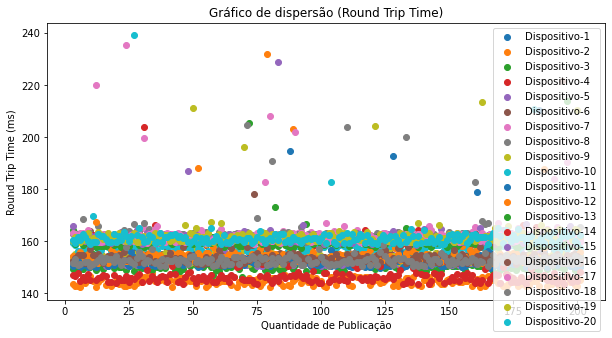

In [13]:
import matplotlib 
i=1
fig, ax = plt.subplots(figsize=(10,5),dpi=72)
for port in ports:
  ax.scatter(data[port]["RTT"].index,data[port]["RTT"], label='Dispositivo-{}'.format(i))
  ax.set_ylabel('Round Trip Time (ms)')
  ax.set_xlabel('Quantidade de Publicação')
  ax.set_title('Gráfico de dispersão (Round Trip Time)')
#   ax.hlines(data[port]["RTT"].max(),  xmin=0, xmax=620, colors="red", linestyles="dashed", label="Maior Medição")
#   ax.hlines(data[port]["RTT"].min(),  xmin=0, xmax=620, colors="green", linestyles="dashed", label="Menor Medição")
  ax.legend()
  i+=1

In [14]:
df_concatenado["RTT"].mean()

156.14371664447197

In [15]:
df_concatenado["RTT"].to_csv("dados.csv", index=False)